# Modelling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_row',50)

In [2]:
DATA_DIR = '../data'

In [3]:
data = pd.read_csv("{}/processed/dataset.csv".format(DATA_DIR))

In [4]:
LABEL = 'roi'

In [5]:
train = data[~pd.isnull(data["points"])]
train["roi"] = train["roi"].fillna(0)
test = data[pd.isnull(data["points"])]

<ipython-input-5-97c2e041d959>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["roi"] = train["roi"].fillna(0)


In [6]:
train.shape

(7137, 114)

In [7]:
test.shape

(634, 114)

In [8]:
train.head()

,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate
0,Aaron Ramsey,2018-09-06 00:00:00,UEFA Nations League,Wales,Republic of Ireland,21.00,90.0,M,2018,9,6,7.0,8.5,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,19,1536,26,29,1484,0.0,2.0,2.0,0.0,4.0,3.0,25.6,1.767500e+09,68000000.0,25.5,7.765000e+08,29900000.0,26.0,183.0,76.0,1.0,82.0,83.0,130000.0,3.0,68.0,75.0,79.0,81.0,65.0,RF,10.0,75.0,75.0,72.0,58.0,84.0,79.0,81.0,70.0,70.0,80.0,82.0,67.0,68.0,76.0,81.0,75.0,81.0,67.0,89.0,69.0,74.0,73.0,69.0,82.0,80.0,75.0,81.0,70.0,67.0,6.0,11.0,5.0,10.0,8.0,52,-10,9.910000e+08,38100000.0,0.1,True,False,1.0,0.823529,False,High,High
1,Aaron Ramsey,2018-09-09 00:00:00,UEFA Nations League,Wales,Denmark,13.50,90.0,M,2018,9,9,2.0,8.5,3.0,7.0,1.0,0.0,7.000000,1.0,0.0,7.0,NaN,NaN,NaN,90.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,1.00,18,19,1536,9,9,1580,0.0,0.0,0.0,0.0,0.0,NaN,25.6,1.767500e+09,68000000.0,27.8,3.107000e+09,119500000.0,26.0,183.0,76.0,1.0,82.0,83.0,130000.0,3.0,68.0,75.0,79.0,81.0,65.0,RF,10.0,75.0,75.0,72.0,58.0,84.0,79.0,81.0,70.0,70.0,80.0,82.0,67.0,68.0,76.0,81.0,75.0,81.0,67.0,89.0,69.0,74.0,73.0,69.0,82.0,80.0,75.0,81.0,70.0,67.0,6.0,11.0,5.0,10.0,8.0,-44,10,-1.339500e+09,-51500000.0,-2.2,True,False,1.0,0.235294,False,High,High
2,Aaron Ramsey,2018-10-11 00:00:00,International Friendlies,Wales,Spain,1.42,90.0,M,2018,10,11,2.0,8.5,3.0,2.0,0.0,0.0,4.500000,0.5,0.0,7.0,3.535534,0.707107,0.0,90.0,1.0,2.0,0.0,0.0,0.0,2.0,NaN,NaN,NaN,1.00,18,19,1536,6,9,1597,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,183.0,76.0,1.0,82.0,83.0,130000.0,3.0,68.0,75.0,79.0,81.0,65.0,RF,10.0,75.0,75.0,72.0,58.0,84.0,79.0,81.0,70.0,70.0,80.0,82.0,67.0,68.0,76.0,81.0,75.0,81.0,67.0,89.0,69.0,74.0,73.0,69.0,82.0,80.0,75.0,81.0,70.0,67.0,6.0,11.0,5.0,10.0,8.0,-61,10,NaN,NaN,NaN,False,False,1.0,0.235294,False,High,High
3,Aaron Ramsey,2018-11-16 00:00:00,UEFA Nations League,Wales,Denmark,2.96,90.0,M,2018,11,16,2.0,8.5,3.0,2.0,0.0,0.0,3.666667,0.0,0.0,7.0,2.886751,0.577350,0.0,90.0,1.0,3.0,0.0,0.0,0.0,4.0,0.0,2.0,2.0,0.75,18,18,1538,9,10,1584,0.0,1.0,0.0,0.0,2.0,2.0,25.6,1.767500e+09,68000000.0,27.8,3.107000e+09,119500000.0,26

In [9]:
train.columns

Index(['player', 'date', 'league_name', 'team_name', 'opponent_name',
       'fantasy_points', 'min', 'position', 'year', 'month',
       ...
       'diff_team_market_value', 'diff_team_mean_market_value',
       'diff_team_mean_squad_age', 'is_senior', 'is_imbalanced',
       'gap_to_potential', 'roi', 'more_likely_to_win', 'attacking_work_rate',
       'defending_work_rate'],
      dtype='object', length=114)

In [10]:
fifa_col = ['attacking_crossing','attacking_heading_accuracy', 'attacking_short_passing',
            'attacking_volleys', 'skill_dribbling', 'skill_curve', 'height_cm', 'weight_kg',
            'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
            'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
            'movement_reactions', 'movement_balance', 'power_shot_power',
            'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
            'mentality_aggression', 'mentality_interceptions',
            'mentality_positioning', 'mentality_vision', 'mentality_penalties',
            'mentality_composure', 'defending_standing_tackle',
            'defending_sliding_tackle', 'goalkeeping_diving',
            'goalkeeping_handling', 'goalkeeping_kicking',
            'goalkeeping_positioning', 'goalkeeping_reflexes', 'pace', 
            'dribbling', 'physic']

In [11]:
columns = ['player', 'league_name', 'date', 'year',
           'points', 'roi', 'value', 'min', 'nation_position',
           'last_md_assists', 'last_md_goals', 'prev_std_assists',
           'month', 'day', 'nation_jersey_number','team_name', 'opponent_name',
           'fantasy_points', 'prev_mean_goals', 'prev_median_min', "prev_std_goals",
           "prev_team_highest_rank" , "prev_opponent_highest_rank", "is_senior", 
           "hth_draw"]

In [12]:
columns += fifa_col

In [13]:
def train_model(df, dropped_cols, label, model):
    X = pd.get_dummies(df.drop(dropped_cols, axis=1))
    y = df[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    mae, mse = mean_absolute_error(y_test, prediction), mean_squared_error(y_test, prediction)
    print(model)
    print("MAE:", mae)
    print("MSE:", mse)
    

In [14]:
model = LGBMRegressor(random_state=1)

In [15]:
train_model(train,columns, "roi", model)

LGBMRegressor(random_state=1)
MAE: 0.29144912041596277
MSE: 0.16550447117628753


In [16]:
train_model(train,columns, "points", model)

LGBMRegressor(random_state=1)
MAE: 1.8358431764092022
MSE: 6.174204972817047


## The Dream Team

In [17]:
X_test = pd.get_dummies(test.drop(columns, axis=1))

In [18]:
def plotImp(model, X , num = 20, fig_size = (9, 3)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.show()

In [19]:
def get_model(df, dropped_cols, label):
    X = pd.get_dummies(df.drop(dropped_cols, axis=1))
    y = df[label]
    model = LGBMRegressor(random_state=1)
    model.fit(X, y)
    print(X.columns)
    plotImp(model,X, 10)
    return model

Index(['skill', 'last_md_points', 'prev_mean_points', 'prev_mean_assists',
       'prev_max_points', 'prev_std_points', 'prev_ratio_starter',
       'count_played', 'goal_consistency', 'assist_consistency',
       'clean_sheet_consistency', 'count_team_played',
       'prev_max_goal_to_specific_opp', 'prev_max_points_to_specific_opp',
       'prev_mean_points_to_specific_opp', 'prev_ratio_played', 'team_rank',
       'team_total_points', 'opponent_rank', 'opponent_total_points',
       'hth_team_win', 'hth_opp_win', 'hth_team_score', 'hth_opp_score',
       'htt_max_margin', 'team_mean_squad_age', 'team_market_value',
       'team_mean_market_value', 'opponent_mean_squad_age',
       'opponent_market_value', 'opponent_mean_market_value', 'age',
       'league_rank', 'overall', 'potential', 'wage_eur',
       'international_reputation', 'shooting', 'passing', 'defending',
       'attacking_finishing', 'diff_team_points', 'diff_team_ranking',
       'diff_team_market_value', 'diff_team_m

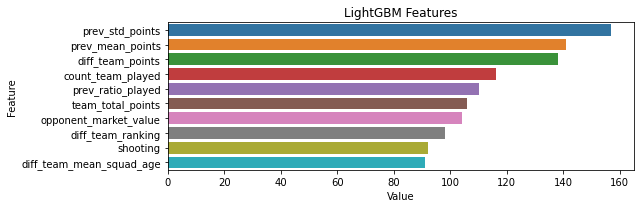

Index(['skill', 'last_md_points', 'prev_mean_points', 'prev_mean_assists',
       'prev_max_points', 'prev_std_points', 'prev_ratio_starter',
       'count_played', 'goal_consistency', 'assist_consistency',
       'clean_sheet_consistency', 'count_team_played',
       'prev_max_goal_to_specific_opp', 'prev_max_points_to_specific_opp',
       'prev_mean_points_to_specific_opp', 'prev_ratio_played', 'team_rank',
       'team_total_points', 'opponent_rank', 'opponent_total_points',
       'hth_team_win', 'hth_opp_win', 'hth_team_score', 'hth_opp_score',
       'htt_max_margin', 'team_mean_squad_age', 'team_market_value',
       'team_mean_market_value', 'opponent_mean_squad_age',
       'opponent_market_value', 'opponent_mean_market_value', 'age',
       'league_rank', 'overall', 'potential', 'wage_eur',
       'international_reputation', 'shooting', 'passing', 'defending',
       'attacking_finishing', 'diff_team_points', 'diff_team_ranking',
       'diff_team_market_value', 'diff_team_m

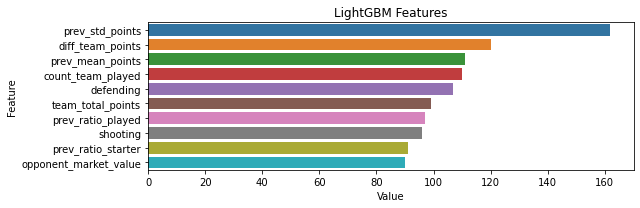

In [20]:
model_1 = get_model(train, columns,'roi')
model_2 = get_model(train, columns,'points')

In [21]:
X_test

,skill,last_md_points,prev_mean_points,prev_mean_assists,prev_max_points,prev_std_points,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,prev_ratio_played,team_rank,team_total_points,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,league_rank,overall,potential,wage_eur,international_reputation,shooting,passing,defending,attacking_finishing,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_imbalanced,gap_to_potential,more_likely_to_win,position_D,position_F,position_GK,position_M,attacking_work_rate_High,attacking_work_rate_Low,attacking_work_rate_Medium,defending_work_rate_High,defending_work_rate_Low,defending_work_rate_Medium
8,3.0,3.0,3.875000,0.000000,13.0,4.155461,0.750000,8.0,0.125000,0.0,0.250000,27.0,NaN,NaN,NaN,0.296296,17,1570,13,1606,1.0,1.0,3.0,4.0,3.0,25.6,1.767500e+09,68000000.0,27.0,2.835000e+09,109000000.0,29.0,1.0,82.0,82.0,98000.0,3.0,77.0,79.0,68.0,75.0,-36,4,-1.067500e+09,-41000000.0,-1.4,False,0.0,False,0,0,0,1,1,0,0,1,0,0
16,3.0,1.0,2.000000,0.333333,4.0,1.732051,0.000000,3.0,0.000000,0.0,0.000000,29.0,NaN,NaN,NaN,0.103448,29,1505,7,1642,0.0,0.0,0.0,0.0,NaN,25.0,3.250000e+09,125000000.0,27.8,7.640000e+09,293800000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-137,22,-4.390000e+09,-168800000.0,-2.8,True,NaN,False,0,0,0,1,0,0,0,0,0,0
19,1.0,1.0,1.000000,0.000000,1.0,0.000000,0.000000,2.0,0.000000,0.0,0.000000,27.0,NaN,NaN,NaN,0.074074,17,1570,13,1606,1.0,1.0,3.0,4.0,3.0,25.6,1.767500e+09,68000000.0,27.0,2.835000e+09,109000000.0,27.0,2.0,70.0,73.0,12000.0,1.0,NaN,NaN,NaN,11.0,-36,4,-1.067500e+09,-41000000.0,-1.4,False,3.0,False,0,0,1,0,0,0,1,0,0,1
20,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,1458,44,1441,1.0,4.0,4.0,7.0,1.0,27.4,1.900000e+09,73100000.0,27.3,2.698500e+09,103800000.0,17.0,1.0,74.0,87.0,500.0,1.0,71.0,68.0,32.0,70.0,17,-4,-7.985000e+08,-30700000.0,0.1,False,13.0,False,0,0,0,0,1,0,0,0,0,1
26,3.0,1.0,1.200000,0.000000,2.0,0.447214,0.200000,5.0,0.000000,0.0,0.000000,27.0,NaN,NaN,NaN,0.185185,6,1648,18,1569,1.0,0.0,4.0,1.0,3.0,26.5,9.150000e+09,381300000.0,29.2,2.150500e+09,82700000.0,24.0,1.0,79.0,85.0,80000.0,1.0,66.0,68.0,38.0,66.0,79,-12,6.999500e+09,298600000.0,-2.7,True,6.0,True,0,0,0,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7708,3.0,1.0,2.227273,0.045455,8.0,1.688387,0.909091,22.0,0.000000,0.0,0.272727,26.0,NaN,NaN,NaN,0.846154,37,1468,5,1666,0.0,2.0,3.0,7.0,3.0,28.1,7.485000e+08,28800000.0,27.9,8.725000e+09,335600000.0,25.0,2.0,72.0,77.0,29000.0,1.0,54.0,73.0,70.0,48.0,-198,32,-7.976500e+09,-306800000.0,0.2,True,5.0,False,0,0,0,1,0,0,1,1,0,0
7733,4.0,5.0,3.416667,0.083333,10.0,2.357535,0.958333,24.0,0.041667,0.0,0.291667,26.0,NaN,NaN,NaN,0.923077,37,1468,5,1666,0.0,2.0,3.0,7.0,3.0,28.1,7.485000e+08,28800000.0,27.9,8.725000e+09,335600000.0,32.0,1.0,71.0,71.0,18000.0,2.0,71.0,59.0,39.0,71.0,-198,32,-7.976500e+09,-306800000.0,0.2,True,0.0,False,0,1,0,0,0,0,1,0,0,1
7735,2.0,2.0,2.000000,0.000000,2.0,NaN,1.000000,1.0,0.000000,0.0,0.000000,26.0,NaN,NaN,NaN,0.038462,37,1468,5,1666,0.0,2.0,3.0,7.0,3.0,28.1,7.485000e+08,28800000.0,27.9,8.725000e+09,335600000.0,24.0,1.0,64.0,72.0,2000.0,1.0,31.0,43.0,65.0,26.0,-198,32,-7.976500e+09,-306800000.0,0.2,True,8.0,False,1,0,0,0,0,1,0,0,0,1
7752,4.0,2.0,3.312500,0.062500,10.0,2.701080,0.750000,16.0,0.062500,0.0,0.312500,27.0,1.0,5.0,5.0,0.592593,6,1648,18,1569,1.0,0.0,4.0,1.0,3.0,26.5,9.150000e+09,381300000.0,29.2,2.150

In [22]:
test["predicted_roi"] = model_1.predict(X_test)
test["predicted_points"] = model_2.predict(X_test)

<ipython-input-22-d6009eb4ca09>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_roi"] = model_1.predict(X_test)
<ipython-input-22-d6009eb4ca09>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_points"] = model_2.predict(X_test)


## Surfacing The Result

In [23]:
fantasy_euro = pd.read_csv("{}/interim/fantasy_euro.csv".format(DATA_DIR))

In [24]:
fantasy_euro = fantasy_euro[["player", "date", "league_name", "team_name", 
                             "opponent_name", "value", "skill", "sel_per"]]

In [25]:
players = pd.merge(test, 
                   fantasy_euro[["player", "sel_per"]],
                   how='left', on="player")

In [26]:
players = players.drop_duplicates(subset=["player", "team_name"])

In [27]:
players = players[~pd.isnull(players['position'])]
players = players[players['prev_ratio_starter'] > 0.75]
players = players[players['prev_ratio_played'] > 0.55]

In [28]:
scaler = StandardScaler()
players["scaled_points"] = scaler.fit_transform(players["predicted_points"].values.reshape(-1,1))
players["scaled_roi"] = scaler.fit_transform(players["predicted_roi"].values.reshape(-1,1))

In [29]:
players["final_score"] = players["scaled_points"] * 0.8 + players["scaled_roi"] * 0.2

In [30]:
players = players.sort_values(by=["final_score"], ascending=False)

In [31]:
col = ["player", "team_name", "opponent_name", "position", 'hth_team_win', 'hth_opp_win', "value", "predicted_roi", "predicted_points", "final_score", "prev_max_points", "prev_mean_points", "prev_std_points", "prev_ratio_starter", "prev_ratio_played"]

In [32]:
views = players[col]

In [33]:
views[views["position"] == "GK"]

,player,team_name,opponent_name,position,hth_team_win,hth_opp_win,value,predicted_roi,predicted_points,final_score,prev_max_points,prev_mean_points,prev_std_points,prev_ratio_starter,prev_ratio_played
642,Wojciech Szczesny,Poland,Slovakia,GK,1.0,1.0,5.0,0.783214,4.412036,1.847303,7.0,3.533333,2.325838,1.0,0.576923
543,Rui Patrício,Portugal,Hungary,GK,2.0,0.0,5.5,0.877824,3.763720,1.352037,7.0,4.315789,2.473249,1.0,0.703704
319,Kasper Schmeichel,Denmark,Finland,GK,1.0,0.0,5.0,0.769365,3.840459,1.272932,7.0,4.375000,2.355613,1.0,0.923077
214,Gianluigi Donnarumma,Italy,Turkey,GK,0.0,0.0,5.5,0.650412,3.950014,1.210816,7.0,4.894737,2.024701,1.0,0.703704
234,Hugo Lloris,France,Germany,GK,4.0,2.0,6.0,0.732207,3.656058,1.041337,7.0,4.263158,2.353298,1.0,0.678571
164,Dominik Livakovic,Croatia,England,GK,1.0,1.0,5.0,0.782676,3.530730,0.991165,7.0,3.277778,1.994273,1.0,0.720000
638,Wayne Hennessey,Wales,Switzerland,GK,1.0,1.0,5.0,0.767404,3.518991,0.958145,7.0,4.000000,2.357023,1.0,0.703704
646,Yann Sommer,Switzerland,Wales,GK,1.0,1.0,5.0,0.696231,3.357758,0.700868,14.0,4.095238,3.144913,1.0,0.807692
596,Thibaut Courtois,Belgium,Russia,GK,4.0,0.0,6.0,0.672734,3.367773,0.677315,7.0,4.666667,2.169305,1.0,0.666667
368,Lukás Hrádecky,Finland,Denmark,GK,0.0,1.0,4.0,0.767844,3.212541,0.661333,8.0,5.050000,2.163696,1.0,0.740741


In [34]:
views[(views["position"] == "D")].head(30)

,player,team_name,opponent_name,position,hth_team_win,hth_opp_win,value,predicted_roi,predicted_points,final_score,prev_max_points,prev_mean_points,prev_std_points,prev_ratio_starter,prev_ratio_played
505,Raphael Guerreiro,Portugal,Hungary,D,2.0,0.0,6.5,0.842511,4.326761,1.848507,6.0,4.176471,2.007339,0.941176,0.629630
69,Benjamin Pavard,France,Germany,D,4.0,2.0,6.0,0.728351,4.407899,1.765599,9.0,3.285714,2.629503,0.952381,0.750000
506,Raphael Varane,France,Germany,D,4.0,2.0,6.0,0.658790,4.472727,1.730015,8.0,3.958333,2.440227,0.916667,0.857143
426,Mehmet Zeki Çelik,Turkey,Italy,D,0.0,0.0,4.5,0.813636,3.796400,1.292861,18.0,3.611111,4.272193,0.944444,0.620690
310,Kamil Glik,Poland,Slovakia,D,1.0,1.0,5.5,0.560650,4.057068,1.187612,12.0,4.000000,3.023716,0.954545,0.846154
27,Andreas Christensen,Denmark,Finland,D,1.0,0.0,5.5,0.756040,3.704758,1.122353,6.0,3.150000,2.400734,0.800000,0.769231
549,Rúben Dias,Portugal,Hungary,D,2.0,0.0,6.0,0.766444,3.669500,1.102865,13.0,3.730769,3.000769,0.961538,0.962963
661,Çaglar Söyüncü,Turkey,Italy,D,0.0,0.0,5.0,0.847744,3.451413,1.006322,12.0,3.529412,3.144790,0.941176,0.586207
564,Simon Kjaer,Denmark,Finland,D,1.0,0.0,4.5,0.718196,3.505094,0.874974,9.0,4.043478,2.513206,0.826087,0.884615
291,João Cancelo,Portugal,Hungary,D,2.0,0.0,6.0,0.744111,3.435101,0.843737,9.0,3.736842,2.725234,0.842105,0.703704


In [35]:
views[(views["position"] == "M")].head(50)

,player,team_name,opponent_name,position,hth_team_win,hth_opp_win,value,predicted_roi,predicted_points,final_score,prev_max_points,prev_mean_points,prev_std_points,prev_ratio_starter,prev_ratio_played
226,Hakan Calhanoglu,Turkey,Italy,M,0.0,0.0,8.5,0.526580,4.712297,1.775316,10.0,4.090909,3.084664,0.909091,0.758621
210,Georginio Wijnaldum,Netherlands,Ukraine,M,0.0,0.0,8.0,0.484898,4.386244,1.399832,18.0,5.280000,4.596375,1.000000,0.925926
597,Thomas Delaney,Denmark,Finland,M,1.0,0.0,5.5,0.610477,4.111087,1.310600,9.0,2.904762,1.972429,1.000000,0.807692
129,David Alaba,Austria,North Macedonia,M,2.0,0.0,5.5,0.596690,4.095298,1.275751,8.0,3.062500,1.982213,1.000000,0.592593
94,Christian Eriksen,Denmark,Finland,M,1.0,0.0,9.0,0.517158,4.127043,1.193938,16.0,5.333333,4.439611,0.916667,0.923077
70,Bernardo Silva,Portugal,Hungary,M,2.0,0.0,8.5,0.610009,3.989974,1.192387,11.0,4.240000,2.989983,0.880000,0.925926
603,Thorgan Hazard,Belgium,Russia,M,4.0,0.0,8.0,0.634592,3.660375,0.907297,12.0,3.850000,2.870448,0.850000,0.740741
76,Bruno Fernandes,Portugal,Hungary,M,2.0,0.0,10.5,0.456829,3.874040,0.862949,8.0,2.631579,2.060489,0.789474,0.703704
494,Piotr Zielinski,Poland,Slovakia,M,1.0,1.0,7.0,0.479333,3.589099,0.618257,7.0,2.818182,1.500361,0.954545,0.846154
640,William Carvalho,Portugal,Hungary,M,2.0,0.0,5.0,0.576659,3.420593,0.592531,7.0,3.058824,1.853058,0.823529,0.629630


In [36]:
views[views["position"] == "F"].head(50)

,player,team_name,opponent_name,position,hth_team_win,hth_opp_win,value,predicted_roi,predicted_points,final_score,prev_max_points,prev_mean_points,prev_std_points,prev_ratio_starter,prev_ratio_played
540,Romelu Lukaku,Belgium,Russia,F,4.0,0.0,11.0,0.564143,5.350700,2.448131,13.0,7.375000,3.263434,1.000000,0.592593
518,Robert Lewandowski,Poland,Slovakia,F,1.0,1.0,11.5,0.423778,4.975962,1.885648,14.0,5.105263,3.710267,0.947368,0.730769
340,Kylian Mbappé,France,Germany,F,4.0,2.0,12.0,0.338493,4.933238,1.723411,12.0,3.900000,3.193744,0.800000,0.714286
106,Cristiano Ronaldo,Portugal,Hungary,F,2.0,0.0,12.0,0.344342,4.768697,1.571994,18.0,5.736842,5.064496,0.947368,0.703704
207,Gareth Bale,Wales,Switzerland,F,1.0,1.0,9.5,0.420121,4.340783,1.263978,9.0,3.350000,2.455391,0.850000,0.740741
49,Antoine Griezmann,France,Germany,F,4.0,2.0,11.0,0.314537,4.408007,1.179709,10.0,4.071429,3.078342,0.928571,1.000000
427,Memphis Depay,Netherlands,Ukraine,F,0.0,0.0,10.0,0.409934,4.212802,1.125337,16.0,5.666667,3.829708,1.000000,0.888889
466,Olivier Giroud,France,Germany,F,4.0,2.0,8.0,0.470818,3.672483,0.687131,10.0,3.653846,2.726790,0.769231,0.928571
399,Marko Arnautovic,Austria,North Macedonia,F,2.0,0.0,7.0,0.478709,3.516758,0.547162,10.0,4.533333,3.020564,0.866667,0.555556
230,Harry Kane,England,Croatia,F,1.0,1.0,11.5,0.290743,3.690523,0.449640,17.0,5.478261,4.541421,0.869565,0.851852
